## Conv1D

### Todos

* Train longer with different window sizes
* Create checkpoints
* Check the whole data mapping procedure, draw the data cube
* Does removing the barometer or helmet sensor help?

In [691]:
%load_ext autoreload
%autoreload 2
%load_ext autotime

# add src to sys-path
import sys
import os
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
sys.path.append('../src')

from data_processing.mtb_data_provider import MtbDataProvider
from visualization.visualize import MtbVisualizer
from models.conv1d_model import Conv1dModel
from models.conv2d_model import Conv2dModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 4.96 ms


In [692]:
WINDOW_SIZE = 6000 # in milliseconds
KERNEL_LENGTH = 10 #in sample data points
KERNEL_HEIGHT = 2
FREQUENCY = 40 # in milliseconds
SAMPLE_SIZE = WINDOW_SIZE // FREQUENCY

print("SAMPLE_SIZE =", SAMPLE_SIZE)

SAMPLE_SIZE = 150
time: 1.57 ms


### Prepare data

<img src="img/input_shape.png" alt="Drawing" style="width: 600px;"/>

#### Conv2d, multiple Sensors and multiple sessions

In [693]:
RAW_FILES = ['neureuth'] # Multiple Sessions ['neureuth', 'anothersession']
VAL_FILE = 'neureuth'

time: 826 µs


In [703]:
"""
This loads all files, named in RAW_FILES and concatenates the final slices
TODO: This should maybe go into the DataProvider as well
"""
X_train = None
y_train = None
for raw_file in RAW_FILES:
    X, y = MtbDataProvider.load_data('../data/raw/' + raw_file, '*?[0-9].csv', frequency=FREQUENCY)
    X = MtbDataProvider.sync_sensors(X)
    X, y = MtbDataProvider.slice_sensors(X, y, window_size=WINDOW_SIZE, frequency=FREQUENCY, step_size=.25)
    
    if X_train is None:
        X_train = X
        y_train = y
    else:
        X_train = np.concatenate((X_train, X))
        y_train = np.concatenate((y_train, y))

X_train.shape #(slices_count, slice_length, sensors_count, sensor_dimensions)

reading  ../data/raw/neureuth_gyr_1.csv
reading  ../data/raw/neureuth_gyr_2.csv
reading  ../data/raw/neureuth_acc_1.csv
reading  ../data/raw/neureuth_acc_2.csv


(965, 150, 4, 3)

time: 950 ms


In [704]:
# IF THERE IS NO VALIDATION SESSION (yet), split 80/20
# Do not run this multiple times in a row, because it overwrites X_train and therefore will get smaller and smaller

from sklearn.model_selection import train_test_split
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=.2, random_state=42, shuffle=False)

time: 7.64 ms


In [696]:
# IF THERE IS A VALIDATION SESSION
#X_dev, y_dev = MtbDataProvider.load_data('../data/raw/' + VAL_FILE, '*?[0-9].csv', frequency=FREQUENCY)
#X_dev = MtbDataProvider.sync_sensors(X_dev)

#X_dev, y_dev = MtbDataProvider.slice_sensors(X_dev, y_dev, window_size=WINDOW_SIZE, frequency=FREQUENCY)
#X_dev.shape

4.0

time: 1.96 ms


In [705]:
print(X_train.shape, y_train.shape)
print(X_dev.shape, y_dev.shape)

(772, 150, 4, 3) (772,)
(193, 150, 4, 3) (193,)
time: 1.05 ms


## Evaluation

### Conv2D, Multiple Sensors

In [724]:
model_cnn2 = Conv2dModel.build_model(input_shape=X_train[0].shape, 
                                     cnn_blocks=3,
                                     dropout=0.3,
                                     kernel_size=(KERNEL_LENGTH, KERNEL_HEIGHT))
# KERNEL_HEIGHT or X_train.shape[2]

time: 402 ms


In [725]:
model_cnn2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_112 (Conv2D)          (None, 150, 4, 3)         183       
_________________________________________________________________
batch_normalization_111 (Bat (None, 150, 4, 3)         12        
_________________________________________________________________
activation_111 (Activation)  (None, 150, 4, 3)         0         
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 150, 4, 8)         488       
_________________________________________________________________
batch_normalization_112 (Bat (None, 150, 4, 8)         32        
_________________________________________________________________
activation_112 (Activation)  (None, 150, 4, 8)         0         
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 75, 4, 8)          0         
__________

In [726]:
model_cnn2.fit(X_train, y_train,
              epochs=200,
              batch_size=16,
              validation_data=(X_dev, y_dev))

Train on 772 samples, validate on 193 samples
Epoch 1/300
772/772 [==============================] - 4s 5ms/step - loss: 2.6939 - sparse_categorical_accuracy: 0.3692 - val_loss: 1.7894 - val_sparse_categorical_accuracy: 0.3834
Epoch 2/300
772/772 [==============================] - 1s 2ms/step - loss: 1.9155 - sparse_categorical_accuracy: 0.5026 - val_loss: 1.5166 - val_sparse_categorical_accuracy: 0.4456
Epoch 3/300
772/772 [==============================] - 1s 2ms/step - loss: 1.4546 - sparse_categorical_accuracy: 0.5868 - val_loss: 1.5647 - val_sparse_categorical_accuracy: 0.4663
Epoch 4/300
772/772 [==============================] - 1s 2ms/step - loss: 1.3654 - sparse_categorical_accuracy: 0.5984 - val_loss: 0.9537 - val_sparse_categorical_accuracy: 0.6943
Epoch 5/300
772/772 [==============================] - 1s 2ms/step - loss: 1.1599 - sparse_categorical_accuracy: 0.6567 - val_loss: 1.6242 - val_sparse_categorical_accuracy: 0.4456
Epoch 6/300
772/772 [============================

Epoch 46/300
772/772 [==============================] - 1s 2ms/step - loss: 0.3675 - sparse_categorical_accuracy: 0.9106 - val_loss: 2.2382 - val_sparse_categorical_accuracy: 0.5026
Epoch 47/300
772/772 [==============================] - 1s 2ms/step - loss: 0.3399 - sparse_categorical_accuracy: 0.9080 - val_loss: 1.4827 - val_sparse_categorical_accuracy: 0.6269
Epoch 48/300
772/772 [==============================] - 1s 2ms/step - loss: 0.3489 - sparse_categorical_accuracy: 0.9145 - val_loss: 1.8440 - val_sparse_categorical_accuracy: 0.5596
Epoch 49/300
772/772 [==============================] - 1s 2ms/step - loss: 0.3468 - sparse_categorical_accuracy: 0.9249 - val_loss: 2.0314 - val_sparse_categorical_accuracy: 0.5078
Epoch 50/300
772/772 [==============================] - 1s 2ms/step - loss: 0.3459 - sparse_categorical_accuracy: 0.9249 - val_loss: 1.6866 - val_sparse_categorical_accuracy: 0.5544
Epoch 51/300
772/772 [==============================] - 1s 2ms/step - loss: 0.3270 - spars

772/772 [==============================] - 1s 2ms/step - loss: 0.2457 - sparse_categorical_accuracy: 0.9521 - val_loss: 2.1033 - val_sparse_categorical_accuracy: 0.5803
Epoch 92/300
772/772 [==============================] - 1s 2ms/step - loss: 0.2624 - sparse_categorical_accuracy: 0.9482 - val_loss: 2.5498 - val_sparse_categorical_accuracy: 0.4819
Epoch 93/300
772/772 [==============================] - 1s 2ms/step - loss: 0.2353 - sparse_categorical_accuracy: 0.9624 - val_loss: 2.2908 - val_sparse_categorical_accuracy: 0.5596
Epoch 94/300
772/772 [==============================] - 1s 2ms/step - loss: 0.2602 - sparse_categorical_accuracy: 0.9430 - val_loss: 1.8724 - val_sparse_categorical_accuracy: 0.6010
Epoch 95/300
772/772 [==============================] - 1s 2ms/step - loss: 0.2339 - sparse_categorical_accuracy: 0.9637 - val_loss: 1.6380 - val_sparse_categorical_accuracy: 0.6010
Epoch 96/300
772/772 [==============================] - 1s 2ms/step - loss: 0.2805 - sparse_categorical

Epoch 136/300
772/772 [==============================] - 1s 2ms/step - loss: 0.1727 - sparse_categorical_accuracy: 0.9741 - val_loss: 1.7143 - val_sparse_categorical_accuracy: 0.6477
Epoch 137/300
772/772 [==============================] - 1s 2ms/step - loss: 0.1897 - sparse_categorical_accuracy: 0.9702 - val_loss: 1.7860 - val_sparse_categorical_accuracy: 0.6218
Epoch 138/300
772/772 [==============================] - 1s 2ms/step - loss: 0.2302 - sparse_categorical_accuracy: 0.9547 - val_loss: 1.9261 - val_sparse_categorical_accuracy: 0.6373
Epoch 139/300
772/772 [==============================] - 1s 2ms/step - loss: 0.1933 - sparse_categorical_accuracy: 0.9715 - val_loss: 1.8261 - val_sparse_categorical_accuracy: 0.6114
Epoch 140/300
772/772 [==============================] - 1s 2ms/step - loss: 0.1825 - sparse_categorical_accuracy: 0.9676 - val_loss: 1.2960 - val_sparse_categorical_accuracy: 0.6839
Epoch 141/300
772/772 [==============================] - 1s 2ms/step - loss: 0.1809 -

Epoch 181/300
772/772 [==============================] - 1s 2ms/step - loss: 0.2094 - sparse_categorical_accuracy: 0.9585 - val_loss: 2.3246 - val_sparse_categorical_accuracy: 0.5440
Epoch 182/300
772/772 [==============================] - 1s 2ms/step - loss: 0.1800 - sparse_categorical_accuracy: 0.9754 - val_loss: 2.0198 - val_sparse_categorical_accuracy: 0.5440
Epoch 183/300
772/772 [==============================] - 1s 2ms/step - loss: 0.2034 - sparse_categorical_accuracy: 0.9624 - val_loss: 1.5551 - val_sparse_categorical_accuracy: 0.6477
Epoch 184/300
772/772 [==============================] - 1s 2ms/step - loss: 0.2216 - sparse_categorical_accuracy: 0.9650 - val_loss: 1.4568 - val_sparse_categorical_accuracy: 0.6580
Epoch 185/300
772/772 [==============================] - 1s 2ms/step - loss: 0.2097 - sparse_categorical_accuracy: 0.9676 - val_loss: 1.5452 - val_sparse_categorical_accuracy: 0.6839
Epoch 186/300
772/772 [==============================] - 1s 2ms/step - loss: 0.1790 -

Epoch 226/300
772/772 [==============================] - 1s 2ms/step - loss: 0.1974 - sparse_categorical_accuracy: 0.9676 - val_loss: 2.7837 - val_sparse_categorical_accuracy: 0.5233
Epoch 227/300
772/772 [==============================] - 1s 2ms/step - loss: 0.1898 - sparse_categorical_accuracy: 0.9650 - val_loss: 1.8781 - val_sparse_categorical_accuracy: 0.6114
Epoch 228/300
772/772 [==============================] - 1s 2ms/step - loss: 0.1995 - sparse_categorical_accuracy: 0.9611 - val_loss: 2.4424 - val_sparse_categorical_accuracy: 0.5389
Epoch 229/300
772/772 [==============================] - 1s 2ms/step - loss: 0.1706 - sparse_categorical_accuracy: 0.9780 - val_loss: 1.2742 - val_sparse_categorical_accuracy: 0.6736
Epoch 230/300
772/772 [==============================] - 1s 2ms/step - loss: 0.1839 - sparse_categorical_accuracy: 0.9754 - val_loss: 2.6473 - val_sparse_categorical_accuracy: 0.4819
Epoch 231/300
772/772 [==============================] - 1s 2ms/step - loss: 0.1571 -

Epoch 271/300
772/772 [==============================] - 1s 2ms/step - loss: 0.1497 - sparse_categorical_accuracy: 0.9858 - val_loss: 1.7024 - val_sparse_categorical_accuracy: 0.6425
Epoch 272/300
772/772 [==============================] - 1s 2ms/step - loss: 0.1674 - sparse_categorical_accuracy: 0.9715 - val_loss: 1.7116 - val_sparse_categorical_accuracy: 0.6373
Epoch 273/300
772/772 [==============================] - 1s 2ms/step - loss: 0.1415 - sparse_categorical_accuracy: 0.9832 - val_loss: 2.1202 - val_sparse_categorical_accuracy: 0.6166
Epoch 274/300
772/772 [==============================] - 1s 2ms/step - loss: 0.1501 - sparse_categorical_accuracy: 0.9793 - val_loss: 2.0477 - val_sparse_categorical_accuracy: 0.6218
Epoch 275/300
772/772 [==============================] - 1s 2ms/step - loss: 0.1942 - sparse_categorical_accuracy: 0.9663 - val_loss: 2.5881 - val_sparse_categorical_accuracy: 0.5389
Epoch 276/300
772/772 [==============================] - 1s 2ms/step - loss: 0.1674 -

time: 6min 44s


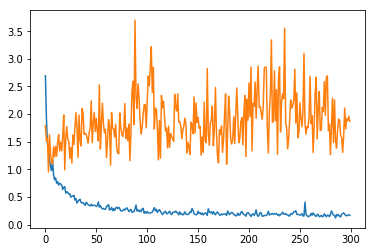

time: 147 ms


In [728]:
plt.plot(model_cnn2.history.history['loss'])
plt.plot(model_cnn2.history.history['val_loss'])
plt.show()

### Predict

### Predicted results

In [729]:
y_pred_dev = model_cnn2.predict(X_dev)
y_pred_dev = np.argmax(y_pred_dev, axis=1)

time: 885 ms


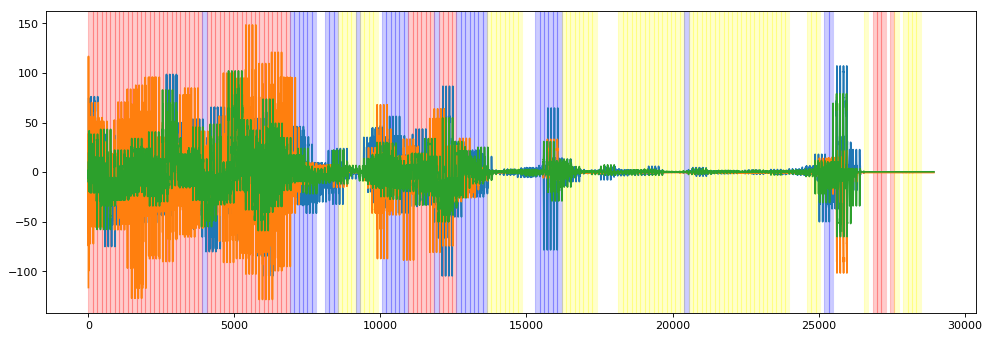

time: 610 ms


In [730]:
# This only plots the first sensor
X_dev_plot = X_dev if len(X_dev.shape) <= 3 else X_dev[:,:,0]
MtbVisualizer.plot_results(X_dev_plot, y_pred_dev, SAMPLE_SIZE)

### Actual results

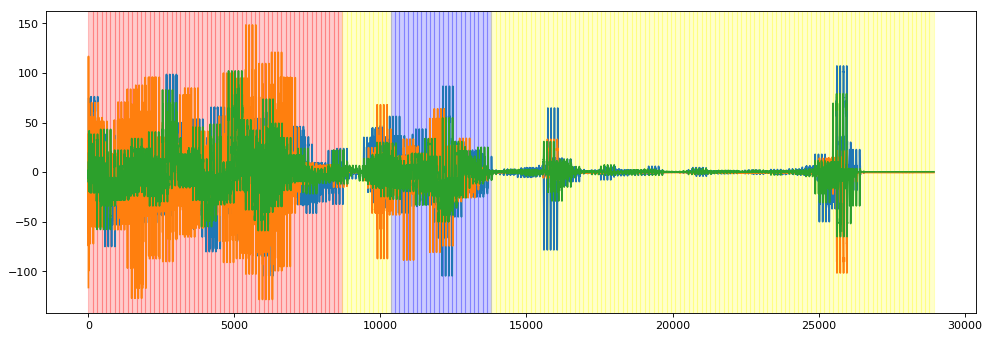

time: 620 ms


In [731]:
MtbVisualizer.plot_results(X_dev_plot, y_dev, SAMPLE_SIZE)

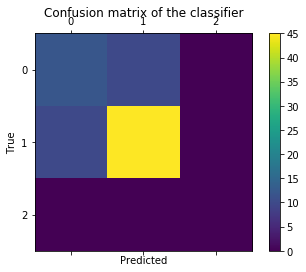

time: 151 ms


In [732]:
MtbVisualizer.print_confusion_matrix(y_dev, y_pred_dev)

### Test on Train data

In [733]:
y_pred_train = model_cnn2.predict(X_train)
y_pred_train = np.argmax(y_pred_train, axis=1)

time: 231 ms


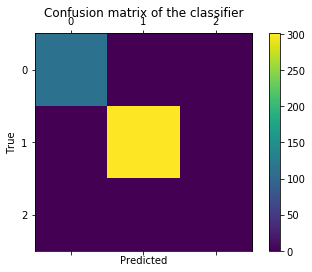

time: 152 ms


In [720]:
MtbVisualizer.print_confusion_matrix(y_train, y_pred_train)

PREDICTED


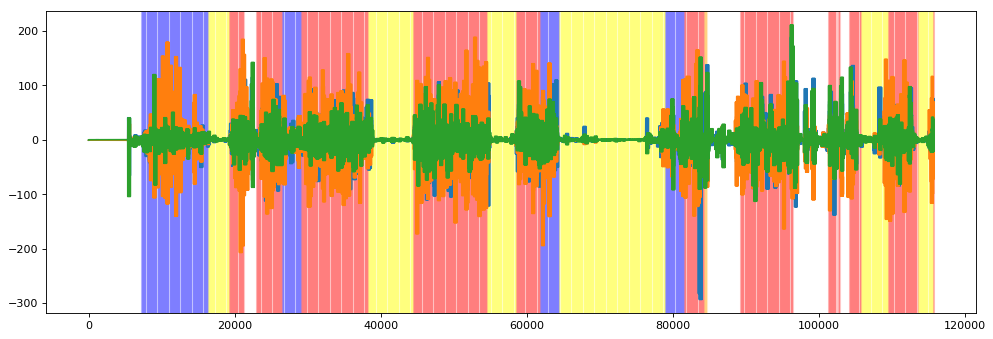

time: 1.85 s


In [734]:
X_train_plot = X_train if len(X_train.shape) <= 3 else X_train[:,:,0]
print('PREDICTED')
MtbVisualizer.plot_results(X_train_plot, y_pred_train, SAMPLE_SIZE)

## Exploration

* 0 = blue = easy
* 1 = red = medium
* 2 = black = hard
* 3 = yellow = standing still
* 4 = white = not on the bike / carrying bike
* 5 = orange = crash

ACTUAL, per sensor


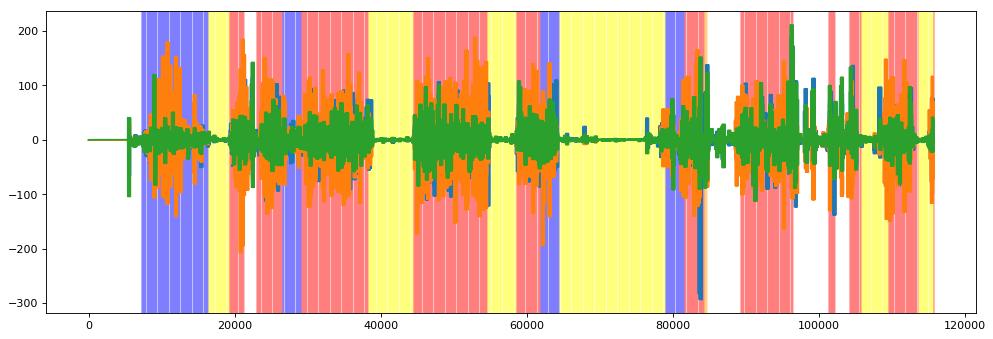

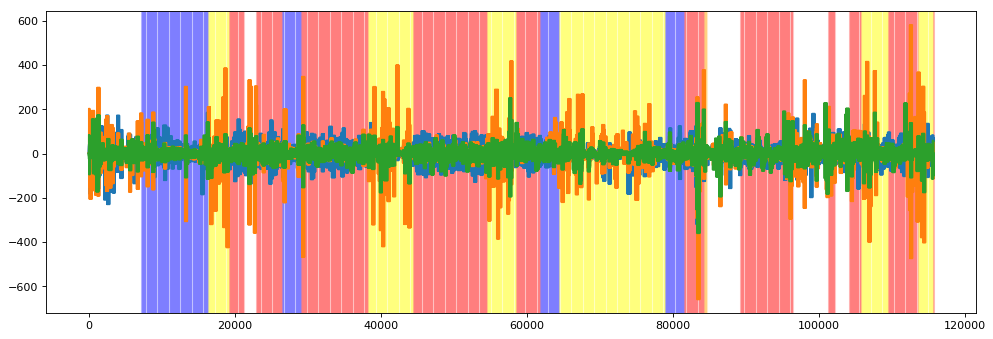

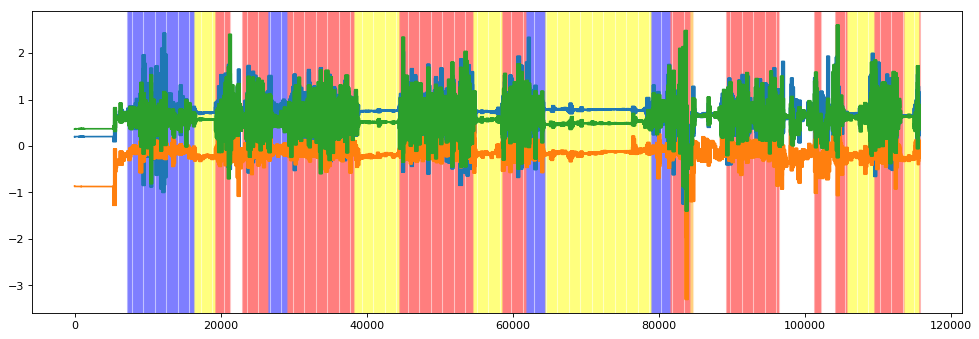

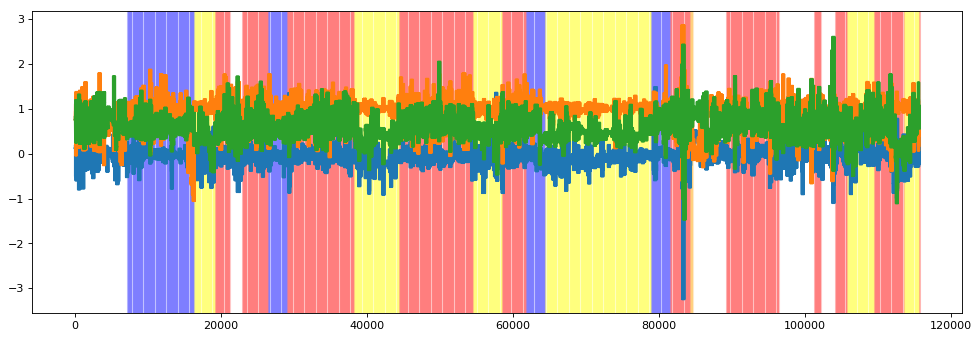

time: 7.7 s


In [722]:
print('ACTUAL, per sensor')
for i in range(0, X_train.shape[2]):
    X_train_plot = X_train if len(X_train.shape) <= 3 else X_train[:,:,i]
    MtbVisualizer.plot_results(X_train_plot, y_train, SAMPLE_SIZE)#[205:220]